In [24]:
import pandas as pd

# Load file CSV
file_path = 'data/uncut/kepler_processed_uncut.csv'
df = pd.read_csv(file_path, comment='#')  # Bỏ qua metadata '#'

# Quan sát dữ liệu
display(df.head())  # Hiển thị 5 dòng đầu
print("Số hàng, số cột:", df.shape)       # Hiển thị kích thước dữ liệu
print("Danh sách cột:", df.columns.tolist())  # Hiển thị danh sách cột

,kepid,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,...,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,1.170922,CONFIRMED,1.186309,-0.043758,-0.550774,-0.496109,-0.369333,-0.049588,0.064131,-0.179360,...,-0.348121,-0.048895,-0.287111,-0.373470,-0.322211,0.369657,-0.133408,-0.026421,1.202764,0.781341
1,1.170922,CONFIRMED,1.115474,-0.043758,-0.550774,-0.496109,-0.369333,-0.015924,-0.054029,-0.045397,...,-0.764839,-0.049435,-0.299923,1.159319,-0.322211,0.369657,-0.133408,-0.026421,1.202764,0.781341
2,1.176212,CANDIDATE,-1.098699,-0.043758,-0.550774,-0.496109,-0.369333,-0.041787,0.142339,0.071212,...,-0.532668,-0.049242,-0.235223,-0.373470,0.187035,0.551135,-0.143226,1.037397,1.200675,0.845587
3,1.190143,FALSE POSITIVE,-1.098699,-0.043758,1.815626,-0.496109,-0.369333,-0.055395,0.060727,0.164682,...,0.368634,-0.043794,0.314798,-0.373470,0.125618,0.598272,-0.156039,-1.369071,1.242630,0.961807
4,1.192441,CONFIRMED,1.186309,-0.043758,-0.550774,-0.496109,-0.369333,-0.054804,0.079692,-0.010384,...,0.381730,-0.043575,-0.280577,-0.373470,0.414789,0.301308,-0.113606,-0.693454,1.226243,0.898283


Số hàng, số cột: (9564, 23)
Danh sách cột: ['kepid', 'koi_disposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag']


In [ ]:
# step 1 : import pandas as pd

# Load file
df = pd.read_csv('data/raw/kepler_data.csv', comment='#')

# Xem thông tin cơ bản
print("Số hàng, số cột:", df.shape)s
print("Danh sách cột:", df.columns.tolist())
print("Số lượng NaN mỗi cột:\n", df.isnull().sum())

In [14]:
# step 2
import pandas as pd

# Load file (đã kiểm tra ở Bước 1)
df = pd.read_csv('data/kepler_data.csv', comment='#')

# Danh sách cột giữ
columns_to_keep = [
    'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol',
    'koi_slogg'
]

# Lọc dữ liệu
df = df[columns_to_keep]

# Xác nhận kết quả
print("\nSố hàng, số cột sau khi lọc:", df.shape)
print("Danh sách cột còn lại:", df.columns.tolist())
print("Số lượng NaN mỗi cột sau khi lọc:\n", df.isnull().sum())


Số hàng, số cột sau khi lọc: (9564, 12)
Danh sách cột còn lại: ['koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol', 'koi_slogg']
Số lượng NaN mỗi cột sau khi lọc:
 koi_disposition      0
koi_period           0
koi_time0bk          0
koi_duration         0
koi_depth          363
koi_prad           363
koi_steff          363
koi_srad           363
koi_model_snr      363
koi_teq            363
koi_insol          321
koi_slogg          363
dtype: int64


In [16]:
# step 3 
import pandas as pd
from sklearn.impute import SimpleImputer

# Load file (dùng dữ liệu đã lọc từ Bước 2)
df = pd.read_csv('data/kepler_data.csv', comment='#')  # Tạm thời load lại, sau này dùng file đã lọc
columns_to_keep = [
    'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol',
    'koi_slogg'
]
df = df[columns_to_keep]

# Chọn cột số để điền NaN
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Xác nhận kết quả
print("\nSố hàng, số cột sau khi điền NaN:", df.shape)
print("Số lượng NaN mỗi cột sau khi điền:\n", df.isnull().sum())


Số hàng, số cột sau khi điền NaN: (9564, 12)
Số lượng NaN mỗi cột sau khi điền:
 koi_disposition    0
koi_period         0
koi_time0bk        0
koi_duration       0
koi_depth          0
koi_prad           0
koi_steff          0
koi_srad           0
koi_model_snr      0
koi_teq            0
koi_insol          0
koi_slogg          0
dtype: int64


In [18]:
# step 4  - normalization 
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import os

# Tạo thư mục processed nếu chưa tồn tại
os.makedirs('data/processed', exist_ok=True)

# Load file raw
df = pd.read_csv('data/kepler_data.csv', comment='#')
columns_to_keep = [
    'koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol',
    'koi_slogg'
]
df = df[columns_to_keep]

# Chuẩn hóa cột số
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Lưu scaler
with open('data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Lưu file dữ liệu đã chuẩn hóa
df.to_csv('data/processed/kepler_processed.csv', index=False)

# Xác nhận kết quả
print("\nSố hàng, số cột sau khi chuẩn hóa:", df.shape)
print("Danh sách cột sau khi chuẩn hóa:\n", df.columns.tolist())
print("Thống kê sau chuẩn hóa:\n", df[numeric_columns].describe())
print("\nFile đã được lưu tại: data/processed/kepler_processed.csv")
print("Scaler đã được lưu tại: data/processed/scaler.pkl")


Số hàng, số cột sau khi chuẩn hóa: (9564, 12)
Danh sách cột sau khi chuẩn hóa:
 ['koi_disposition', 'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_steff', 'koi_srad', 'koi_model_snr', 'koi_teq', 'koi_insol', 'koi_slogg']
Thống kê sau chuẩn hóa:
          koi_period   koi_time0bk  koi_duration     koi_depth      koi_prad  \
count  9.564000e+03  9.564000e+03   9564.000000  9.201000e+03  9.201000e+03   
mean  -9.658151e-18  3.090608e-16      0.000000 -4.942369e-17  6.177961e-18   
std    1.000052e+00  1.000052e+00      1.000052  1.000054e+00  1.000054e+00   
min   -5.651530e-02 -6.724150e-01     -0.860674 -2.892978e-01 -3.340787e-02   
25%   -5.464830e-02 -4.921053e-01     -0.492003 -2.873535e-01 -3.297895e-02   
50%   -4.938923e-02 -4.263930e-01     -0.282637 -2.841773e-01 -3.265725e-02   
75%   -2.619080e-02  6.642606e-02      0.101201 -2.713816e-01 -2.858248e-02   
max    9.734218e+01  1.923480e+01     20.539943  1.845381e+01  6.506740e+01   

          koi

In [9]:
import pandas as pd
import numpy as np

# Load file CSV
file_path = 'data/kepler_data.csv'
df = pd.read_csv(file_path, comment='#')

# Kiểm tra trường có toàn 0
zero_columns = (df == 0).all()
print("Các trường có toàn bộ giá trị = 0:")
print(df.columns[zero_columns].tolist())

# Kiểm tra trường có NaN
nan_columns = df.isnull().any()
print("\nCác trường có giá trị NaN:")
print(df.columns[nan_columns].tolist())

# Thống kê số lượng NaN mỗi cột
print("\nSố lượng NaN mỗi cột:")
print(df.isnull().sum())

Các trường có toàn bộ giá trị = 0:
[]

Các trường có giá trị NaN:
['kepler_name', 'koi_score', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_kepmag']

Số lượng NaN mỗi cột:
kepid                   0
kepoi_name              0
kepler_name          6817
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1      

<Axes: xlabel='koi_period', ylabel='Count'>

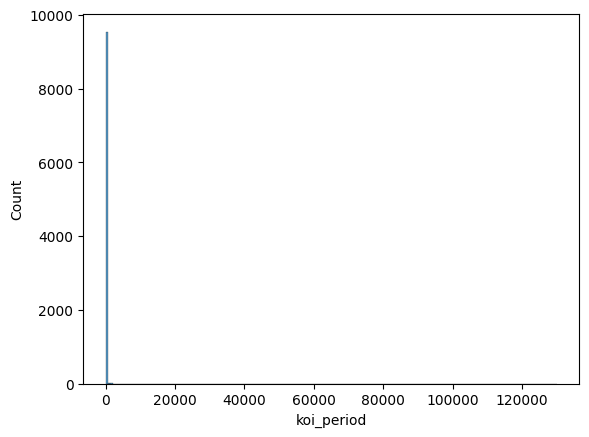

In [7]:
import seaborn as sns

# Vẽ biểu đồ phân phối chu kỳ quỹ đạo
sns.histplot(data=df, x='koi_period')